In [9]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O /tmp/rps.zip
  
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O /tmp/rps-test-set.zip

--2020-07-17 14:39:05--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.187.128, 64.233.188.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.187.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘/tmp/rps.zip’

/tmp/rps.zip        100%[===================>] 191.38M   122MB/s    in 1.6s    

2020-07-17 14:39:07 (122 MB/s) - ‘/tmp/rps.zip’ saved [200682221/200682221]

--2020-07-17 14:39:09--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.187.128, 64.233.188.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.187.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘/tmp

In [10]:
import os
import zipfile

local_zip = '/tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')

local_zip = '/tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

# Loading Images and Preprocessing

In [11]:
rock_dir = os.path.join('/tmp/rps/rock')
paper_dir = os.path.join('/tmp/rps/paper')
scissors_dir = os.path.join('/tmp/rps/scissors')

print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

rock_files = os.listdir(rock_dir)
paper_files = os.listdir(paper_dir)
scissors_files = os.listdir(scissors_dir)

print(rock_files[:10])
print(paper_files[:10])
print(scissors_files[:10])

total training rock images: 840
total training paper images: 840
total training scissors images: 840
['rock05ck01-073.png', 'rock01-100.png', 'rock01-039.png', 'rock05ck01-035.png', 'rock05ck01-106.png', 'rock06ck02-115.png', 'rock05ck01-088.png', 'rock05ck01-116.png', 'rock07-k03-027.png', 'rock04-015.png']
['paper01-081.png', 'paper02-063.png', 'paper04-049.png', 'paper05-034.png', 'paper04-022.png', 'paper06-072.png', 'paper07-105.png', 'paper03-112.png', 'paper07-057.png', 'paper03-109.png']
['scissors02-047.png', 'testscissors03-024.png', 'scissors01-005.png', 'scissors01-076.png', 'scissors01-055.png', 'testscissors01-081.png', 'scissors02-097.png', 'testscissors03-087.png', 'testscissors02-037.png', 'testscissors02-091.png']


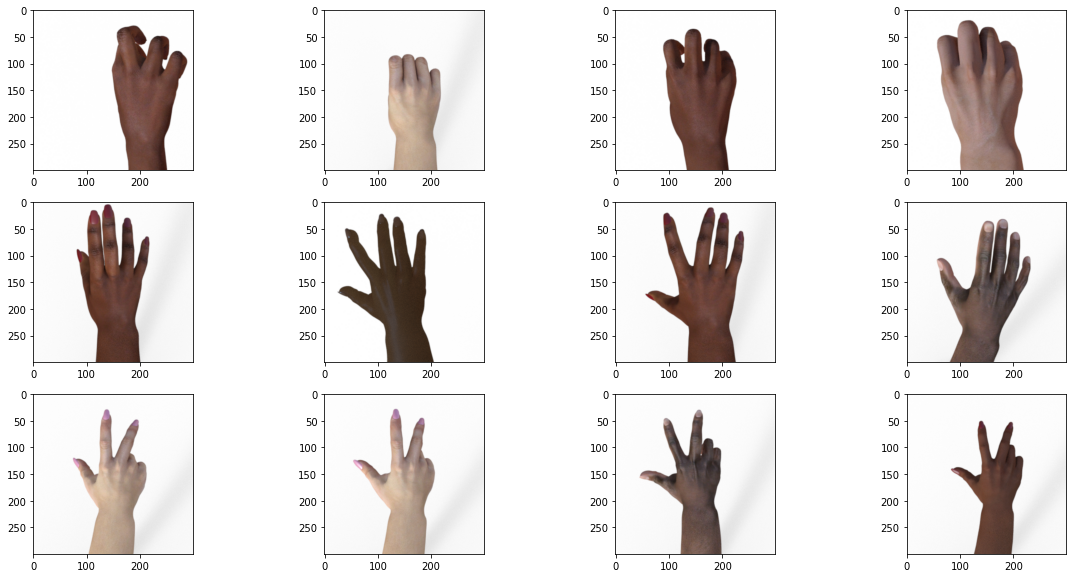

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

plt.figure(figsize=(20, 10))

for i in range(4):
  plt.subplot(3, 4, i+1)
  n = random.randrange(len(os.listdir(rock_dir)))
  img = mpimg.imread(os.path.join(rock_dir, rock_files[n]))
  plt.imshow(img)

  plt.subplot(3, 4, i+5)
  n = random.randrange(len(os.listdir(paper_dir)))
  img = mpimg.imread(os.path.join(paper_dir, paper_files[n]))
  plt.imshow(img)

  plt.subplot(3, 4, i+9)
  n = random.randrange(len(os.listdir(scissors_dir)))
  img = mpimg.imread(os.path.join(scissors_dir, scissors_files[n]))
  plt.imshow(img)

# Creating Model

In [13]:
from keras_preprocessing.image import ImageDataGenerator

training_datagen = ImageDataGenerator(rescale = 1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale = 1./255)

# flow from directory
train_generator = training_datagen.flow_from_directory('/tmp/rps/',
                                                       target_size = (150, 150),
                                                       class_mode = 'categorical',
                                                       batch_size = 126)
validation_generator = validation_datagen.flow_from_directory('/tmp/rps-test-set//',
                                                       target_size = (150, 150),
                                                       class_mode = 'categorical',
                                                       batch_size = 126)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [14]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dropout(0.5),

    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),

    tf.keras.layers.Dense(3, activation='softmax')
])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [16]:
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(train_generator,
                    epochs=25,
                    validation_data = validation_generator,
                    verbose = 1)

Epoch 1/25
20/20 [==============================] - 24s 1s/step - loss: 1.7607 - accuracy: 0.3492 - val_loss: 1.0967 - val_accuracy: 0.3333
Epoch 2/25
20/20 [==============================] - 24s 1s/step - loss: 1.0968 - accuracy: 0.3766 - val_loss: 1.0746 - val_accuracy: 0.3333
Epoch 3/25
20/20 [==============================] - 24s 1s/step - loss: 1.0040 - accuracy: 0.4821 - val_loss: 0.7376 - val_accuracy: 0.6532
Epoch 4/25
20/20 [==============================] - 24s 1s/step - loss: 0.9160 - accuracy: 0.5651 - val_loss: 1.3328 - val_accuracy: 0.3360
Epoch 5/25
20/20 [==============================] - 24s 1s/step - loss: 0.8517 - accuracy: 0.6016 - val_loss: 0.6885 - val_accuracy: 0.6478
Epoch 6/25
20/20 [==============================] - 24s 1s/step - loss: 0.7965 - accuracy: 0.7151 - val_loss: 0.8801 - val_accuracy: 0.4866
Epoch 7/25
20/20 [==============================] - 24s 1s/step - loss: 0.6019 - accuracy: 0.7476 - val_loss: 0.8421 - val_accuracy: 0.6478
Epoch 8/25
20/20 [==

# Visulaizing Model Performance

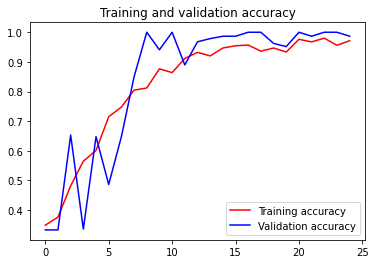

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

# Validate

get validation data @ https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-validation.zip

In [19]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)